<img src="https://pbs.twimg.com/profile_images/969600936321736704/WrwKmb8y_400x400.jpg" width="200" height="200" />

# Fitting Growth Response
Rather than model the sensitivities, we can model the growth curve directly. For simplicity, lets assume the the growth factor curve has a gaussian shape, with 3 parameters, a $\mu$ which determines the location of the curve, $\sigma$ which determines the width and $A$ (Normalisation) which determines the height.
$$ A\exp{(-0.5((T-\mu)/\sigma)^2)}$$

The growth curve should be the same for all countries and states. Lets fit this on the US states growing Maize.

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import stan
import nest_asyncio
nest_asyncio.apply()



%matplotlib inline

In [2]:
# Read in climate temperatures
clim_precip_maize=pd.read_table('./Crop_data_files/clim_file/temp_climatology_Maize.csv')
clim_precip_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)

### Define states to fit over
As we are modelling the growth function with respect to temperature, we need to use the absolute temperature measurements rather than anomalies. Lets add back the climatological mean to the anomalies.

In [3]:
states=['Indiana','Illinois', 'Ohio','Nebraska', 'Iowa','Minnesota']

In [4]:
#Read in and add back mean temperature to get real temperature values
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_temp.iloc[:,1:].add(clim_precip_maize[
        clim_precip_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]].iloc[0,1:,])
    temp_states.append(tmp)
temp_states=pd.concat(temp_states,keys=states)

In [5]:
temp_states

Jan       Feb       Mar        Apr        May        Jun  \
Indiana   0  -1.953404 -3.973006  2.590578  10.088053  17.326414  20.962442   
          1  -4.008832  0.874847  4.869181  13.945699  15.277813   22.68807   
          2   -6.41284 -2.598794  4.783799    8.75127  19.956611  19.564509   
          3  -0.465296   1.96229  6.155099   9.137945  15.119583  22.140624   
          4  -5.105456  3.228889  0.673888  10.326888  15.366284  23.747983   
...                ...       ...       ...        ...        ...        ...   
Minnesota 30 -3.894967 -1.749772  9.135808   15.05992   17.47543  22.453567   
          31 -4.428446 -0.934544  3.876822  10.931225  16.691369   22.26014   
          32  2.490363  4.015216  13.52965  13.723302  19.899771  24.097072   
          33 -0.870058 -0.306576  1.553864   7.754037  16.777378  21.930891   
          34 -5.511097 -5.582699   2.46772  10.251231  17.230989  22.757721   

                    Jul        Aug        Sep        Oct       Nov       Dec  
Indiana   0    25.56639  24.883075  20.269487  11.389179  5.570661  0.147049  
          1   23.961534  22.508911  18.441564  11.863837  7.139047 -1.290255  
          2   24.183623  21.621206  18.324091  13.481793  7.370094  4.991934  
          3    26.05522  25.653142  19.800115  13.684522  7.847771 -5.461258  
          4   22.762473  23.506537  18.667095   15.53397  6.184882  3.995697  
...                 ...        ...        ...        ...       ...       ...  
Minnesota 30  24.983107  25.496559  18.378626  15.090358  7.361888  -1.73295  
          31  26.449608  23.989601  18.724605  15.673464  9.089504  4.738137  
          32  27.667796  23.654424  19.756353  12.557708  8.402349  2.157232  
          33  24.304695   23.91813  21.893929  12.689224  6.059128 -3.676043  
          34  22.845252  23.780614  19.961778  13.604165  2.571968  3.395782  

[210 rows x 12 columns]

As a first attempt, lets use the yield anomalies data and add back a constant 6. We will deal with fitting the Yield trend due to efficiency later.

In [6]:
# Read in Yields
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [7]:
yields

,Unnamed: 0,Region,1960,1961,1962,1963,1964,1965,1966,1967,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0,Maize_Spring_USA_Nebraska,-0.06276,-0.15690,0.40794,0.00000,-0.40794,0.00000,0.37656,0.00000,...,0.00000,-0.50208,0.00000,0.00000,1.00416,0.18828,-0.37656,-1.506240,0.28242,0.62760
1,1,Maize_Spring_USA_Iowa,-0.75312,-0.04707,0.00000,0.15690,-0.15690,0.00000,0.03138,-0.03138,...,0.12552,-0.31380,0.00000,0.00000,0.62760,-0.37656,0.43932,-1.757280,-0.25104,0.87864
2,2,Maize_Spring_USA_Illinois,-0.69036,-0.18828,0.31380,0.12552,-0.31380,0.43932,-0.50208,0.62760,...,-1.31796,-0.75312,0.06276,0.31380,0.00000,0.00000,0.00000,-3.263520,0.65898,1.38072
3,3,Maize_Spring_USA_Indiana,-0.37656,-0.25104,0.50208,0.31380,-0.62760,0.50208,-0.37656,-0.12552,...,0.00000,0.00000,-0.18828,0.18828,0.87864,0.00000,-0.69036,-3.640080,0.97278,0.69036
4,4,Maize_Spring_USA_Minnesota,-0.34518,0.15690,0.00000,0.50208,-0.18828,-0.50208,0.25104,-0.25104,...,0.94140,0.00000,-1.00416,0.00000,0.75312,0.75312,-0.62760,0.376560,0.09414,-0.18828
5,5,Maize_Spring_USA_Ohio,-0.37656,-0.06276,0.12552,0.25104,-0.69036,-0.25104,0.31380,-0.31380,...,-0.81588,0.56484,0.00000,-1.75728,1.12968,0.43932,-0.43932,-2.510400,0.65898,0.12552
6,6,Maize_Spring_China_Jilin,-0.23500,0.11935,-0.03450,-0.04300,0.05020,-0.05020,0.00000,0.13240,...,0.18101,0.58294,-0.18101,0.54988,-0.45689,-0.54988,0.00000,0.194480,0.08097,NaN
7,7,Maize_Spring_China_Liaoning,-0.49600,-0.05390,0.00000,0.00000,0.00000,0.00000,0.00000,0.17770,...,0.01228,-0.19889,-0.26599,0.46488,-0.93963,-0.81114,0.00000,0.039145,0.51029,NaN
8,8,Maize_Spring_China_Heilongjiang,1.41700,-0.28565,0.00000,0.07270,-0.09070,-0.00440,0.00000,0.35160,...,0.38670,0.00000,-0.98415,0.28129,-0.28129,0.00000,0.26910,-0.134550,0.07151,NaN
9,9,Maize_Summer_China_Hebei,-0.10190,0.05095,0.01090,-0.17080,0.00000,0.00000,0.15120,0.07440,...,0.00000,0.00000,0.00079,0.10930,-0.04865,-0.06144,0.00000,0.004350,0.07125,NaN


In [9]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':len(states),
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,3:9]).reshape(
        len(states),int(np.array(temp_states.iloc[:,3:9]).shape[0]/len(states)),6).astype(float),
    'd_yields':np.array(yields[yields["Region"].isin(
        ['Maize_Spring_USA_'+s for s in states])].iloc[:,22:]).astype(float)+9.75,
    'n_gf':40,
    'temp':np.arange(0,40,1)

}

Lets read in our Stan model and compile

In [11]:
with open('stan/BMSM-GaussGR.stan', 'r') as f:
    model= f.read()

# Compile model
sm=stan.build(model, data, random_seed=1308)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan__c430d5b/model_5mu3yw3f.stan', line 32, column 12: Argument 20 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


Lets fit the model and look at summary statistics

In [12]:
fit=sm.sample(num_chains=4,num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (102/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (601/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  55% (4400/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000552 seconds
  1000 transitions using 10 leapfrog steps per tr

In [13]:
# fit
df = fit.to_frame()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4000.0,-71.927051,1.191907,-80.295341,-72.474422,-71.627570,-71.060100,-70.477766
accept_stat__,4000.0,0.938095,0.093905,0.133839,0.920011,0.976702,0.995998,1.000000
stepsize__,4000.0,0.152882,0.017517,0.134928,0.136876,0.149755,0.165762,0.177090
treedepth__,4000.0,3.515750,1.027626,1.000000,3.000000,4.000000,4.000000,6.000000
n_leapfrog__,4000.0,18.060000,10.341041,1.000000,7.000000,15.000000,31.000000,63.000000
...,...,...,...,...,...,...,...,...
pred_yields.2.35,4000.0,9.984160,0.984665,6.724384,9.329406,9.976973,10.653191,13.584917
pred_yields.3.35,4000.0,10.059658,1.014413,5.966088,9.377389,10.064740,10.745252,13.815972
pred_yields.4.35,4000.0,10.221817,1.011838,6.619848,9.536319,10.219562,10.901944,14.453987


In [16]:
# validat from original code
fit['sigma']

array([[6.56582681, 5.92492773, 6.50192933, ..., 5.93495568, 5.66442715,
        5.76250781]])

We now use some more sophisticated diagnostics to check the inference is behaving properly

In [17]:
fit['treedepth__']

array([[5., 2., 4., ..., 2., 4., 4.]])

In [41]:
# carry out some diagnostic checks on fit
from xidplus.stan_fit import stan_utility
stan_utility.check_div(fit)
stan_utility.check_energy(fit)
stan_utility.check_treedepth(fit)

0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [42]:
samples=fit.extract()

## Examine posterior samples
Now lets take a detailed look at the posterior samples from the fit. We will examine:
1. The posterior distribution on the growth curve parameters
2. The posterior distribution on the growth curve
3. Posterior predicitive checks (i.e. comparing predicited yield to real world yield)

In [19]:
fit['fdy'].T.shape

(4000, 40)

Text(0, 0.5, '$dy$ [tonnes ha$^{-1}$]')

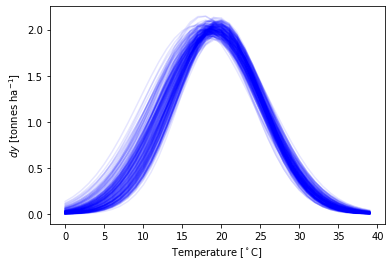

In [20]:
#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(data['temp'],fit['fdy'].T[i,:],alpha=0.1, c='b')
plt.xlabel('Temperature [$^\circ$C]')
plt.ylabel(r'$dy$ [tonnes ha$^{-1}$]')
#plt.title('Growth Curve')1d_Gauss_temp_post_sample_growth_curve
# plt.savefig('./figs/1d_Gauss_temp_post_sample_growth_curve.pdf')
# plt.savefig('./figs/1d_Gauss_temp_post_sample_growth_curve.png')

The figure above shows growth curve samples from the posterior. Each curve is a possible growth curve. Where the lines overlap most represents the curve is known more precisely at these points, compared to where the lines are more spaced indicating there is more uncertianty. Our results indicate that the high temperature tail to the growth curve is known to a good degree of precison where as the the low temperature tail is more uncertian.

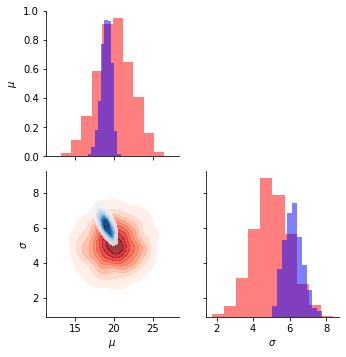

In [25]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([20,5]),
                                              np.array([[5.0,0.0],[0.0,1.0]]),2000),columns=['$\mu$','$\sigma$'])
g=sns.PairGrid(data=df,height=2.5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10, shade=True,thresh=0.05)
df=pd.DataFrame(np.vstack((fit['mu'],fit['sigma'])).T,columns=['$\mu$','$\sigma$'])
g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10, shade=True,thresh=0.05)

g.axes[0,1].set_axis_off()


# plt.savefig("./figs/output.png")

The figure above shows the prior (red) and posterior (blue) distribution for our parameters of the growth function. The bottom left plot shows the 2D distribution of $\mu$ and $\sigma$, and plotted alongside are the two 1D marginalised probability distributions. It is clear that the infered posterior probability distribution has significantly shrunk compared to prior, indicating the fit is being driven by the data.

## Posterior Predictive Checks
Lets now do a couple of posterior predicitive checks. Lets first visualise the predicited yield distributions coming from the model with a violin plot and plot the real yield data on top.

In [26]:
fit

<stan.Fit>
Parameters:
    mu: ()
    sigma: ()
    norm: ()
    fdy: (40,)
    pred_yields: (6, 35)
Draws: 4000

In [31]:
fit['pred_yields'].T.shape

(4000, 35, 6)

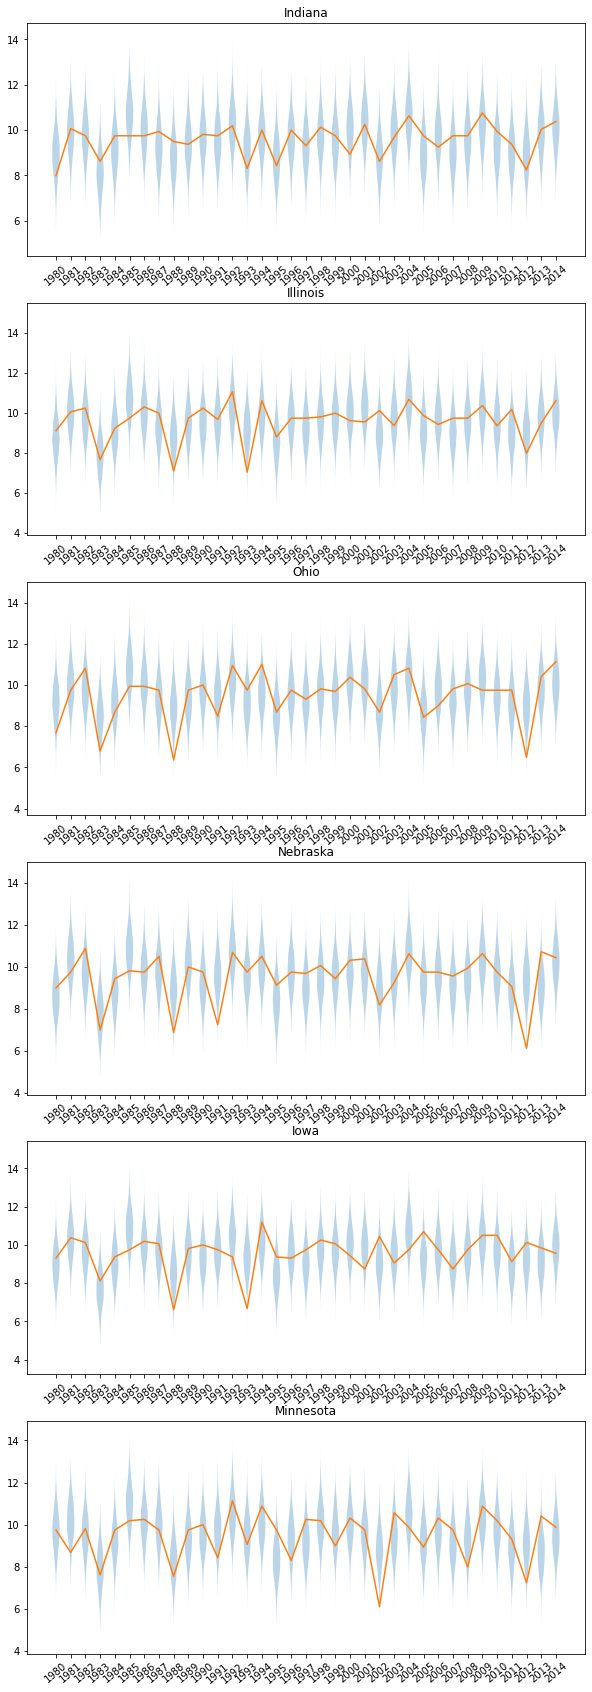

In [36]:
plt.figure(figsize=(10,5*len(states)))
for s in range(0,len(states)):
    plt.subplot(len(states),1,s+1)
    plt.violinplot(fit['pred_yields'].T[:,:,s],showextrema=False);
    plt.xticks(range(1,36),np.arange(1980,2015),rotation=40);
    plt.plot(range(1,36),data['d_yields'][s,:])
    plt.title(states[s])

Most points lie in the distribution, indiciating a reasonable fit. Lets now quantify

### Posterior Predictive checking and Bayesian P-value maps

When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, [Gelman et al. 1996](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf) is a good starting point.

For our case, the best way to carry out posterior predictive checks is to think about the yield in one year. We can look at where the real yield value is in relation to the distribution from $y^{rep}$. 

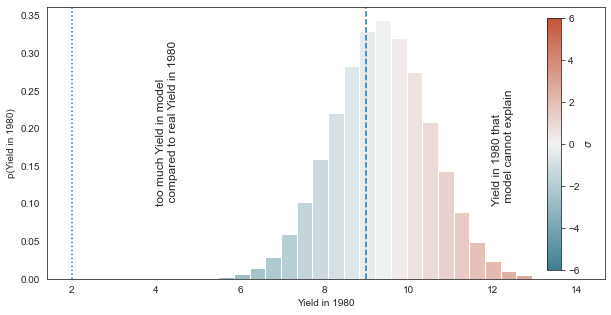

In [47]:
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(fit['pred_yields'].T[:,:,0], 25, density=True)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(fit['pred_yields'][:,:,0]))/np.std(fit['pred_yields'][:,:,0]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('Yield in 1980')
plt.ylabel('p(Yield in 1980)')
plt.axvline(9, linestyle='--') # how are these picked and what for?
plt.axvline(2,linestyle=':')
plt.annotate('Yield in 1980 that \n model cannot explain',xy=(8, 0.01),  xycoords='data',
            xytext=(12, 0.1), textcoords='data',rotation='vertical',size='large')
plt.annotate('too much Yield in model \n compared to real Yield in 1980',xy=(3, 0.01),  xycoords='data',
            xytext=(4, 0.1), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

We can calculate fraction of $y^{rep}$ samples above and below real yield value. This is often referred to as the Bayesian p-value and is telling us the probability of drawing the real yield value, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* $\sim 0.5$ means our model is consistent with the data 
* 0.99 or 0.01 means model is missing something.

We can convert this to a typical '$\sigma$' level.

In [53]:
def Bayesian_Pval(yields,pred_yields):
    import scipy.stats as st
    Pvals=np.empty_like(yields)
    n_reg,n_years=yields.shape
    for r in range(0,n_reg):
        for y in range(0,n_years):
            ind=pred_yields[r,y,:]<yields[r,y]
            Pvals[r,y]=st.norm.ppf(ind.sum()/pred_yields[r,y,:].size)
    return Pvals

In [51]:
fit['pred_yields'].shape

(6, 35, 4000)

In [50]:
data['d_yields'].shape

(6, 35)

In [54]:
Pvals=Bayesian_Pval(data['d_yields'],fit['pred_yields'])

Text(0, 0.5, 'P value')

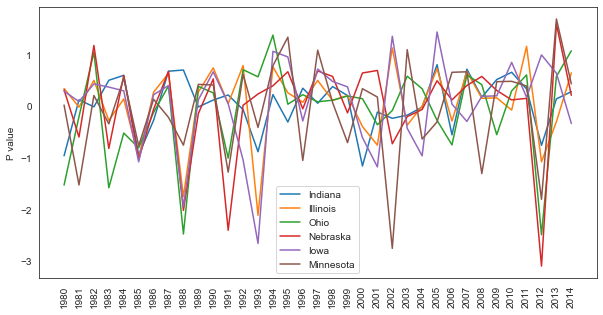

In [57]:
plt.figure(figsize=(10,5))
for s in range(0,len(states)):
    plt.plot(Pvals[s,:],label=states[s])
plt.xticks(range(0,35),np.arange(1980,2015),rotation=90);
plt.legend()
plt.ylabel('P value')

# plt.savefig("./figs/pvalues_all.png".format(states[s]))
# plt.savefig("./figs/pvalues_all.pdf".format(states[s]))

The plot above shows the P values for every state. Most years are between -1 and 1, indicating that the yields are a good fit given the uncertianties in model. The exceptions are 1988,1991, 1993 2002 and 2012 where the yield was dramatically lower than predicited. This would suggest a failure in the model, most likely being the assumption of 

# Fit Yield trend

In [94]:
np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,21:]).astype(float)

array([[ 0.12552, -1.75728,  0.3138 ,  0.     , -1.12968,  0.     ,
         0.     ,  0.     ,  0.18828, -0.25104, -0.37656,  0.06276,
         0.     ,  0.43932, -1.44348,  0.25104, -1.31796,  0.25104,
        -0.43932,  0.37656,  0.     , -0.81588,  0.50208, -1.12968,
        -0.06276,  0.87864,  0.     , -0.50208,  0.     ,  0.     ,
         1.00416,  0.18828, -0.37656, -1.50624,  0.28242,  0.6276 ],
       [ 0.75312, -0.6276 ,  0.3138 ,  0.50208, -2.07108, -0.50208,
         0.     ,  0.56484,  0.25104, -2.63592,  0.     ,  0.50208,
        -0.06276,  1.31796, -2.69868,  0.87864, -0.9414 ,  0.     ,
         0.     ,  0.06276,  0.25104, -0.12552, -0.18828,  0.37656,
        -0.37656,  0.9414 ,  0.12552, -0.3138 ,  0.     ,  0.     ,
         0.6276 , -0.37656,  0.43932, -1.75728, -0.25104,  0.87864],
       [ 1.00416, -2.07108,  0.     ,  1.06692, -2.94972, -1.06692,
         0.18828,  0.18828,  0.     , -3.38904,  0.     ,  0.25104,
        -1.2552 ,  1.19244,  0.     ,  1.2552 

In [64]:
states

['Indiana', 'Illinois', 'Ohio', 'Nebraska', 'Iowa', 'Minnesota']

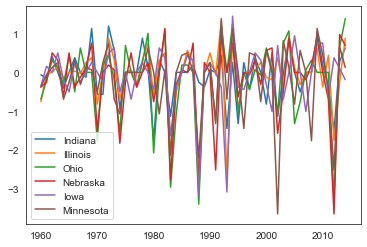

In [126]:
np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,21]).astype(float)
plt.plot(np.arange(1960,2015,1),np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,2:]).astype(float).T, label=states)
plt.legend()

# are the right states in the legend with the right colours?

In [104]:
# np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,21]).astype(float)
np.arange(1960,2015,1)

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [123]:
yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,1:]

,Region,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,Maize_Spring_USA_Nebraska,-0.06276,-0.15690,0.40794,0.00000,-0.40794,0.00000,0.37656,0.00000,-0.12552,...,0.00000,-0.50208,0.00000,0.00000,1.00416,0.18828,-0.37656,-1.50624,0.28242,0.62760
1,Maize_Spring_USA_Iowa,-0.75312,-0.04707,0.00000,0.15690,-0.15690,0.00000,0.03138,-0.03138,0.25104,...,0.12552,-0.31380,0.00000,0.00000,0.62760,-0.37656,0.43932,-1.75728,-0.25104,0.87864
2,Maize_Spring_USA_Illinois,-0.69036,-0.18828,0.31380,0.12552,-0.31380,0.43932,-0.50208,0.62760,0.00000,...,-1.31796,-0.75312,0.06276,0.31380,0.00000,0.00000,0.00000,-3.26352,0.65898,1.38072
3,Maize_Spring_USA_Indiana,-0.37656,-0.25104,0.50208,0.31380,-0.62760,0.50208,-0.37656,-0.12552,0.12552,...,0.00000,0.00000,-0.18828,0.18828,0.87864,0.00000,-0.69036,-3.64008,0.97278,0.69036
4,Maize_Spring_USA_Minnesota,-0.34518,0.15690,0.00000,0.50208,-0.18828,-0.50208,0.25104,-0.25104,0.00000,...,0.94140,0.00000,-1.00416,0.00000,0.75312,0.75312,-0.62760,0.37656,0.09414,-0.18828
5,Maize_Spring_USA_Ohio,-0.37656,-0.06276,0.12552,0.25104,-0.69036,-0.25104,0.31380,-0.31380,0.12552,...,-0.81588,0.56484,0.00000,-1.75728,1.12968,0.43932,-0.43932,-2.51040,0.65898,0.12552
